In [1]:
import numpy as np
from matplotlib import pyplot as plt
import keras

RANDOM_SEED = 0xdeadbeef


# Neural Networks 2

# Task 1. Keras (3 Points)

In this task we will revisit [keras](https://keras.io).
We will work with the MNIST hand-written digit recognition dataset. in the first part we describe in detail how the neural network is setup. In the second part, you will train and optimize the network using dropout.

In the next cell we will load the MNIST data and do some light preprocessing.

In [2]:
from keras.datasets import mnist

# download official train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# the original image data are 8bit integers, we normalize them to floats in [0., 1.]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# the original labels are the digits 0-9
# that means an image of a written "0" has label 0.
# here we transform these to so-called one-hot vectors
# the one-hot vector has 10 dimensions (one for each class)
# and is all 0 except for the dimension corresponding to the label
# for example, label 2 would be encoded as [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
# this conversion is necessary for training with keras
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

print("train samples: ", x_train.shape[0])
print("test samples: ", x_test.shape[0])

print("shape of one sample: ", x_train[0].shape)

print("train samples labels: ", y_train.shape)
print("test samples labels: ", y_test.shape)

train samples:  60000
test samples:  10000
shape of one sample:  (28, 28)
train samples labels:  (60000, 10)
test samples labels:  (10000, 10)


Here we visualize the first few training samples:

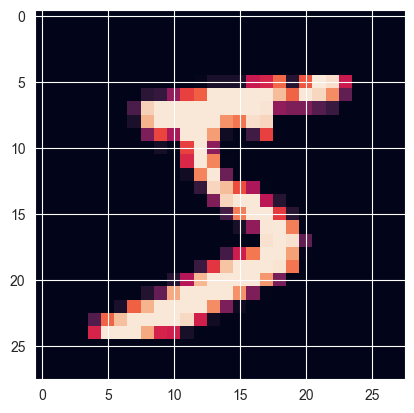

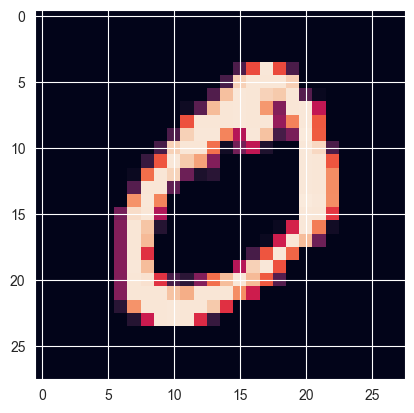

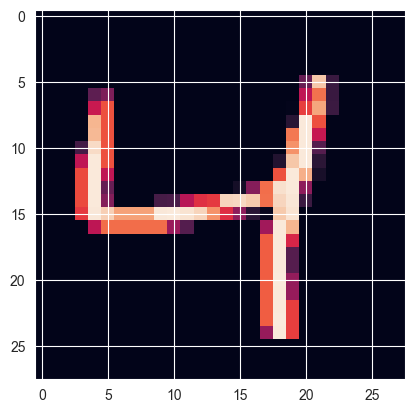

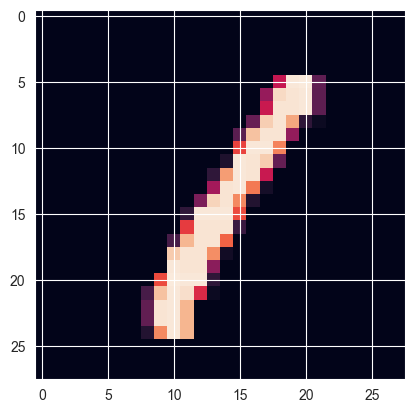

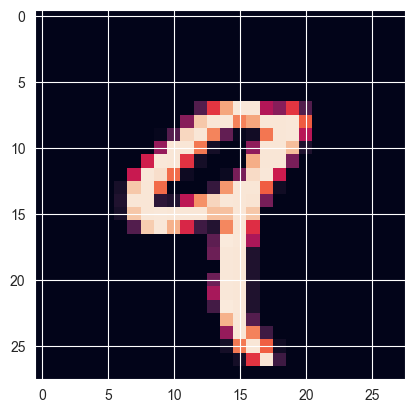

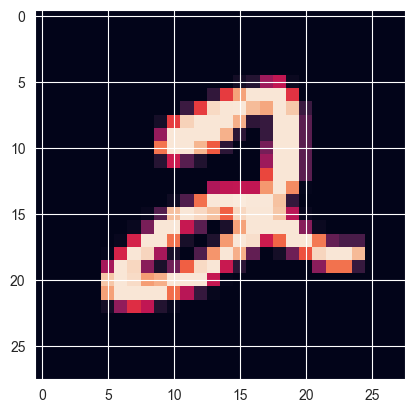

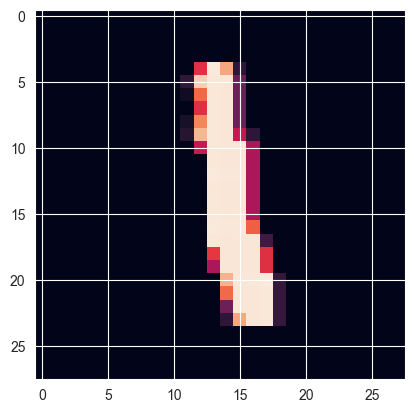

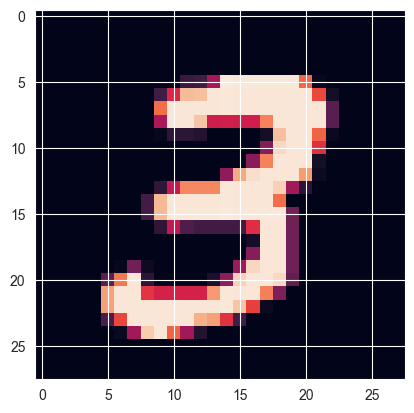

In [3]:
for i in range(8):
  plt.imshow(x_train[i, :, :])
  plt.show()

In the next cell, we define a simple feed-forward neural network.

Compared to last week there are a few changes:

We do not use separate `Activation` layers, but instead specify the activation function using the keyword argument `activation` of the `Dense` layers.

We explicitely define the shape of the input using an `Input` layer. The MNIST images are all 28 pixels wide and 28 pixels high.

This week we will not yet consider the 2D nature of images but flatten them and treat them as 28x28 = 784 dimensional vectors. This is achieved by the `Flatten` layer.

We use 10 output nodes, since we have 10 classes. The output layer uses softmax activation for classification (as seen in class).

In [4]:
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense

model = Sequential()
model.add(Input(shape=(28, 28)))  # define input shape, here 28x28 images
model.add(Flatten())              # flatten 28x28 images to 784-dimensional vectors
model.add(Dense(128, activation="relu"))    # hidden layer with 128 nodes and relu activation
model.add(Dense(10, activation="softmax"))  # output layer with 10 nodes (for 10 classes) and softmax activation

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In the next cell, we prepare the model for training. We specify `"categorical_crossentropy"` as our loss function. This corresponds to the loss function for multi-class classification that you have seen in class. We will `optimizer="sgd"` to train using stochastic gradient descent, and report accuracy.

In [5]:
model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In the next cell, we fit the model on our training data. We use `batch_size=16` and train for `epochs=20` epochs.

We additionally use the keyword argument `validation_split=.1`. This tells the training procedure to split the training data into 90% for training and 10% for validation, similarly to how we used the scikit-learn `train_test_split` function in previous assignments.

During training, keras will report loss and accuracy on both the training and validation split for each epoch and store them in the history output object.

In [6]:
history = model.fit(
  x_train,
  y_train,
  batch_size=16,
  epochs=40,
  validation_split=.1,
)

Epoch 1/40
3375/3375 [==============================] - 5s 2ms/step - loss: 0.5206 - accuracy: 0.8625 - val_loss: 0.2653 - val_accuracy: 0.9272
Epoch 2/40
3375/3375 [==============================] - 6s 2ms/step - loss: 0.2876 - accuracy: 0.9188 - val_loss: 0.2099 - val_accuracy: 0.9428
Epoch 3/40
3375/3375 [==============================] - 6s 2ms/step - loss: 0.2384 - accuracy: 0.9327 - val_loss: 0.1791 - val_accuracy: 0.9503
Epoch 4/40
3375/3375 [==============================] - 6s 2ms/step - loss: 0.2058 - accuracy: 0.9410 - val_loss: 0.1586 - val_accuracy: 0.9557
Epoch 5/40
3375/3375 [==============================] - 6s 2ms/step - loss: 0.1820 - accuracy: 0.9476 - val_loss: 0.1430 - val_accuracy: 0.9623
Epoch 6/40
3375/3375 [==============================] - 6s 2ms/step - loss: 0.1632 - accuracy: 0.9534 - val_loss: 0.1348 - val_accuracy: 0.9642
Epoch 7/40
3375/3375 [==============================] - 6s 2ms/step - loss: 0.1481 - accuracy: 0.9579 - val_loss: 0.1223 - val_accuracy:

In the next cell we provide a helper function to plot the training and validation losses.

In [7]:
def plot_history(history: keras.callbacks.History):
  """
  plot the training and validation loss for each training epoch

  history: a History object, output of the .fit method of a keras model
  """
  n = len(history.history['loss'])
  plt.plot(np.arange(n), history.history['loss'], label="training loss")
  plt.plot(np.arange(n), history.history['val_loss'], label="validation loss")
  plt.xticks(range(0, n + 1, 2))
  plt.legend()
  plt.show()

Next, we plot the learning curves:

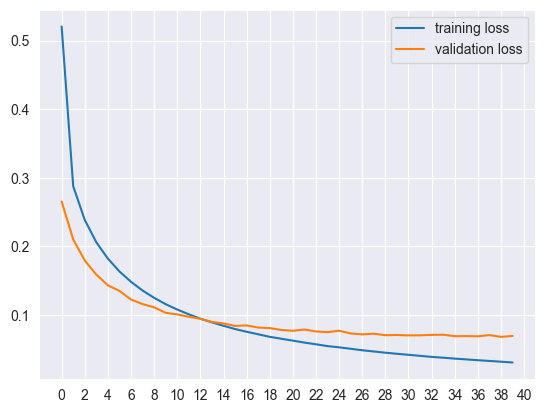

In [8]:
plot_history(history)

Finally, we can evaluate our model on the test data.
The `.evaluate` method takes the test samples and labels as input and returns a list of values. The first entry in the list is the loss over the test data, the following values are the additional metrics that we defined in the `.compile` method. In our case it will return the test loss and the accuracy on the test set.
You can also check `model.metrics_names` to check which value corresponds to which metric.

In [9]:
for metric_name, metric_value in zip(model.metrics_names, model.evaluate(x_test, y_test)):
  print(metric_name, f"{metric_value:.4f}", sep="\t")

313/313 [==============================] - 1s 2ms/step - loss: 0.0723 - accuracy: 0.9771
loss	0.0723
accuracy	0.9771


### Task 1a. Add a Dropout layer

In the next cell, we redefine the same model as above. Your task is to add a `Dropout` layer. The main argument for the dropout layer is `rate` which defines the fraction of nodes that should be dropped. For example `Dropout(rate=0.5)` would drop exactly half of the nodes every time.

**Note:** If you ever use another framework than keras, their dropout implementation might be defined such that you specify the fraction of nodes to keep.

**Task**: add a `Dropout` layer after the hidden layer and set an appropriate `rate` parameter.

In [10]:
from keras.layers import Dropout

# TODO: add a Dropout layer
model_dropout = Sequential()
model_dropout.add(Input(shape=(28, 28)))
model_dropout.add(Flatten())
model_dropout.add(Dense(128, activation="relu"))
model_dropout.add(Dropout(rate=.7))
model_dropout.add(Dense(10, activation="softmax"))

model_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Below, we train the model in the same way as before.

In [11]:
model_dropout.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
history = model_dropout.fit(
  x_train,
  y_train,
  batch_size=16,
  epochs=20,
  validation_split=.1,
)

Epoch 1/20
3375/3375 [==============================] - 7s 2ms/step - loss: 0.8487 - accuracy: 0.7392 - val_loss: 0.2917 - val_accuracy: 0.9263
Epoch 2/20
3375/3375 [==============================] - 6s 2ms/step - loss: 0.5076 - accuracy: 0.8497 - val_loss: 0.2284 - val_accuracy: 0.9388
Epoch 3/20
3375/3375 [==============================] - 6s 2ms/step - loss: 0.4371 - accuracy: 0.8722 - val_loss: 0.2002 - val_accuracy: 0.9448
Epoch 4/20
3375/3375 [==============================] - 6s 2ms/step - loss: 0.3931 - accuracy: 0.8844 - val_loss: 0.1795 - val_accuracy: 0.9513
Epoch 5/20
3375/3375 [==============================] - 7s 2ms/step - loss: 0.3713 - accuracy: 0.8937 - val_loss: 0.1646 - val_accuracy: 0.9537
Epoch 6/20
3375/3375 [==============================] - 7s 2ms/step - loss: 0.3510 - accuracy: 0.8975 - val_loss: 0.1566 - val_accuracy: 0.9588
Epoch 7/20
3375/3375 [==============================] - 6s 2ms/step - loss: 0.3324 - accuracy: 0.9034 - val_loss: 0.1469 - val_accuracy:

Below we plot the learning curve of the model with dropout.

**Task**: Compare the learning curves to the model without dropout. What changed? Why?

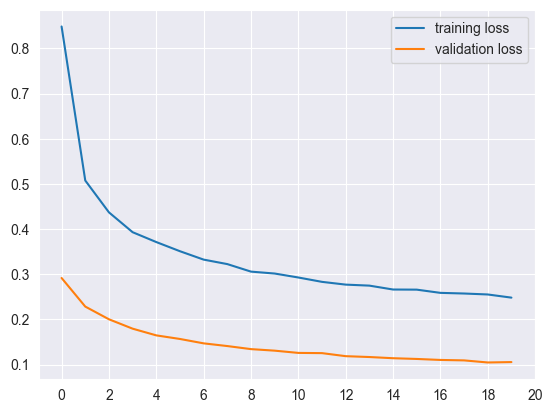

In [12]:
plot_history(history)

Finally, we can evaluate our model with dropout on the test data.

In [13]:
for m, v in zip(model_dropout.metrics_names, model_dropout.evaluate(x_test, y_test)):
  print(m, f"{v:.4f}")

313/313 [==============================] - 1s 2ms/step - loss: 0.1266 - accuracy: 0.9613
loss 0.1266
accuracy 0.9613


## 📢 **HAND-IN** 📢: in Moodle (2 Points)

* The learning curve plot for your model with dropout
* What difference did you observe to the learning curves without dropout?
* What is your explanation for the difference?

### Task 1b. Early Stopping "by hand"

In this task we will again consider the intial model without dropout. We will again plot the learning curves. Your task will be to study the learning curve and decide whether early stopping makes sense and determine at which epoch we should stop.

In the next cell, we rerun the training of our initial model without dropout. We use a few more epochs this time.

**Note** this might take a little longer to run.

In [14]:

# define same model, without dropout again
model = Sequential()
model.add(Input(shape=(28, 28)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(10, activation="softmax"))

# note: we use more epochs for this task
model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
history = model.fit(
  x_train,
  y_train,
  batch_size=16,
  epochs=40,
  validation_split=.1,
)


Epoch 1/40
3375/3375 [==============================] - 7s 2ms/step - loss: 0.5232 - accuracy: 0.8618 - val_loss: 0.2628 - val_accuracy: 0.9293
Epoch 2/40
3375/3375 [==============================] - 7s 2ms/step - loss: 0.2882 - accuracy: 0.9189 - val_loss: 0.2112 - val_accuracy: 0.9403
Epoch 3/40
3375/3375 [==============================] - 7s 2ms/step - loss: 0.2384 - accuracy: 0.9321 - val_loss: 0.1791 - val_accuracy: 0.9500
Epoch 4/40
3375/3375 [==============================] - 7s 2ms/step - loss: 0.2053 - accuracy: 0.9420 - val_loss: 0.1599 - val_accuracy: 0.9577
Epoch 5/40
3375/3375 [==============================] - 8s 2ms/step - loss: 0.1811 - accuracy: 0.9486 - val_loss: 0.1426 - val_accuracy: 0.9642
Epoch 6/40
3375/3375 [==============================] - 7s 2ms/step - loss: 0.1619 - accuracy: 0.9544 - val_loss: 0.1322 - val_accuracy: 0.9648
Epoch 7/40
3375/3375 [==============================] - 7s 2ms/step - loss: 0.1467 - accuracy: 0.9590 - val_loss: 0.1225 - val_accuracy:

**Task** study the learning curves in the next plot. Does early stopping makes sense? If so, at what epoch should we have stopped and why?

**Note** your solution will very likely look very different from other people's.

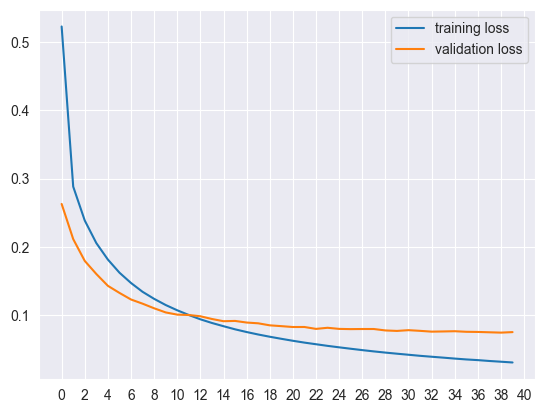

In [15]:
plot_history(history)

## 📢 **HAND-IN** 📢: in Moodle (1 Point)

* the plot of the learning curve in Task 1b.
* should we use early stopping?
* at what epoch would you stop?

### Early Stopping in Keras

Keras provides an implementation of early stopping using the `EarlyStopping` class.

We can define a parameters to control how early stopping is applied. The general idea is to stop training once a particular metric does not improve any more. We want to stop training once the validation loss does not decrease anymore. For this we set `monitor="val_loss"` to tell it to check the values of the validation loss. Since we want to stop once we achive a minimal validation loss, we set `mode="min"`. Finally, we set `patience=1` to tell it to stop training after the validation loss has not improved for 1 whole epoch.

We then pass the `EarlyStopping` instance as a callback to the `.fit` method, using `callbacks=[early_stopping]`. Keras implements several functionalities using callbacks that run at the end of every epoch, early stopping is one of them.

Epoch 1/40
3375/3375 [==============================] - 9s 2ms/step - loss: 0.5317 - accuracy: 0.8614 - val_loss: 0.2658 - val_accuracy: 0.9280
Epoch 2/40
3375/3375 [==============================] - 8s 2ms/step - loss: 0.2903 - accuracy: 0.9176 - val_loss: 0.2147 - val_accuracy: 0.9418
Epoch 3/40
3375/3375 [==============================] - 8s 2ms/step - loss: 0.2408 - accuracy: 0.9314 - val_loss: 0.1851 - val_accuracy: 0.9510
Epoch 4/40
3375/3375 [==============================] - 8s 2ms/step - loss: 0.2069 - accuracy: 0.9417 - val_loss: 0.1589 - val_accuracy: 0.9605
Epoch 5/40
3375/3375 [==============================] - 8s 2ms/step - loss: 0.1820 - accuracy: 0.9481 - val_loss: 0.1460 - val_accuracy: 0.9625
Epoch 6/40
3375/3375 [==============================] - 8s 2ms/step - loss: 0.1624 - accuracy: 0.9544 - val_loss: 0.1311 - val_accuracy: 0.9655
Epoch 7/40
3375/3375 [==============================] - 8s 2ms/step - loss: 0.1466 - accuracy: 0.9590 - val_loss: 0.1215 - val_accuracy:

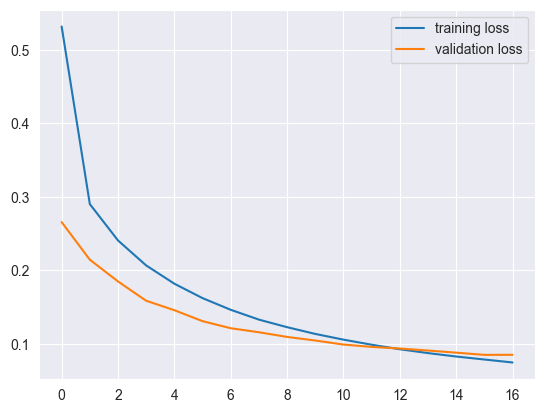

In [16]:
from keras.callbacks import EarlyStopping

# prepare our model
model = Sequential()
model.add(Input(shape=(28, 28)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(10, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=1,
)

# note that we pass the early_stopping object as a callback here
history = model.fit(
  x_train,
  y_train,
  batch_size=16,
  epochs=40,
  validation_split=.1,
  callbacks=[early_stopping]
)

plot_history(history)


# Task 2 Data Augmentation (2 Points)

In this task we will look at some image data augmentation methods that are implemented in keras.

In the next cell we prepare the data used for this task. We will use the first 8 samples from the MNIST training data. As mentioned, the original MNIST images are 28x28 pixels and each pixel consists of 1 float value. The keras image processing functions expect inputs with shape (width, height, channels) where channels usually is 3, corresponding to red, green, and blue. We therefore have to reshape our images to have shape (28, 28, 1), we achieve this using `np.newaxis` when indexing the original data. Don't worry, you do not have to understand that last part.

In [17]:
# You don't have to fully understand this next line
X = x_train[:8, :, :, np.newaxis]

print("new data shape: ", X.shape)
print("number of samples: ", X.shape[0])
print("shape of an individual sample", X.shape[1:])

new data shape:  (8, 28, 28, 1)
number of samples:  8
shape of an individual sample (28, 28, 1)


In the next cell, we use several classes implementing various image augmentation strategies.

Since they all involve a degree of randomness, we can set their random seed using `seed=RANDOM_SEED`.

The first augmentation we can use is `RandomFlip`. As the name suggests, it will randomly flip a given input image. We can set `mode` to any of: `"horizontal"`, `"vertical"`, or `"horizontal_and_vertical"`.

Next, we can use `RandomRotation` which will rotate the input image by a random amount. The maximal angle of the rotation is defined by the `factor` parameter. It represents the maximal fraction of $2\pi$ that we will rotate in either direction. Since rotating an image can move certain pixels outside of the initial 28x28 grid and leave certain pixels empty, we have to define what to do with the empty space. We can define this by setting `fill_mode`. Here we chose `fill_mode="constant"` and a `fill_value=0.0` to fill empty pixels with 0. There are other fill-modes available but you do not have to worry about that this week.

The last augmentation we will look at is `RandomZoom`. It has both a `height_factor` and `width_factor` which defines how much we can zoom in or out in either dimension. We again provide `fill_mode="constant"` and `fill_value=0.` for the same reasons.

**Task** the values of the three augmentation layers are intentionally set too extreme. Your task is to find good values for:
* `mode` of `RandomFlip`
* `factor` of `RandomRotation`
* `height_factor` and `width_factor` of `RandomZoom`

There is one layer which does not make much sense for the digit recognition task. You can remove it.

In [18]:
from keras.layers import RandomFlip, RandomRotation, RandomZoom

augmentation_layer = Sequential()
augmentation_layer.add(Input(shape=(28, 28, 1)))
augmentation_layer.add(RandomFlip(mode="horizontal_and_vertical", seed=RANDOM_SEED))
augmentation_layer.add(RandomRotation(factor=.5, seed=RANDOM_SEED, fill_mode="constant", fill_value=0.))
augmentation_layer.add(RandomZoom(height_factor=1., width_factor=1., fill_mode="constant", fill_value=0.))

In the next cell, we apply the augmentations to our samples. Note that we pass the parameter `training=True`, since data augmentation is only applied during training but not testing (similar to dropout).

In [19]:
x_aug = augmentation_layer(X, training=True)

In the next cell, we plot all 8 example images and their augmented versions.

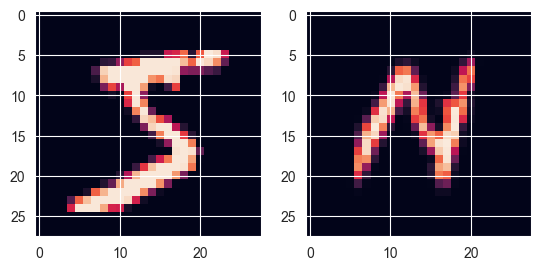

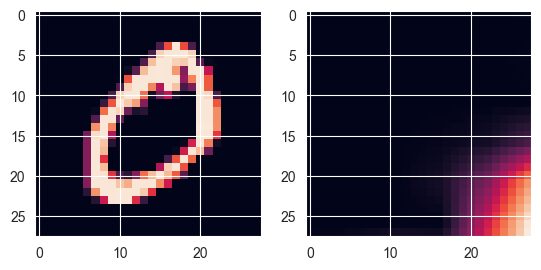

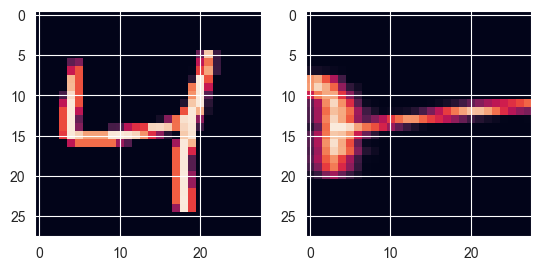

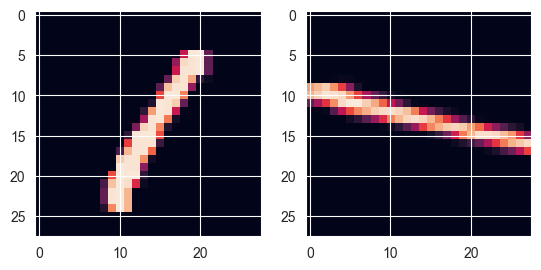

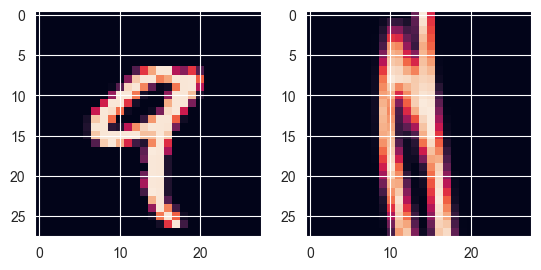

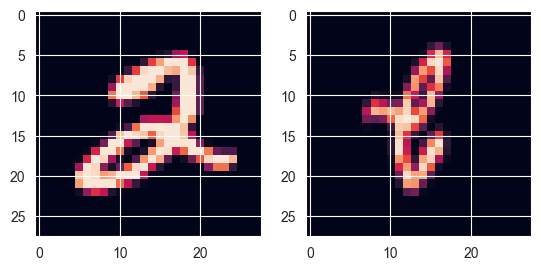

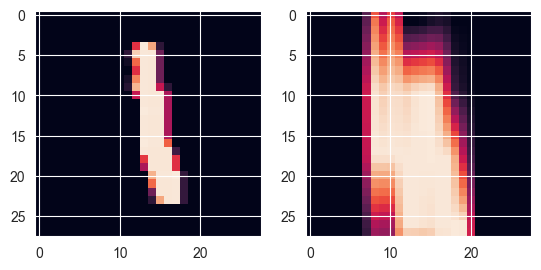

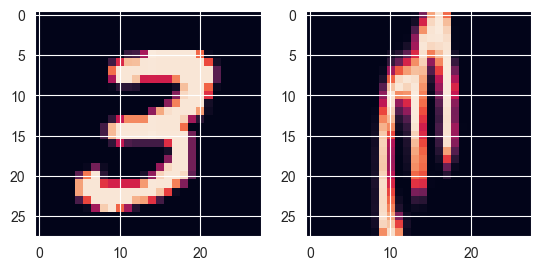

In [20]:
for i in range(8):
  ax1 = plt.subplot(1, 2, 1)
  ax1.imshow(X[i, :, :, 0])
  ax2 = plt.subplot(1, 2, 2)
  ax2.imshow(x_aug[i, :, :, 0])
  plt.show()

## 📢 **HAND-IN** 📢: in **Moodle** whether you solved this task

# Task 3. The Deep End (5 Points)

In this task you are on your own. We will provide you with a dataset and you will have to implement your own feed-forward neural network using keras.

The dataset we will use is the [Boston Housing Dataset](http://lib.stat.cmu.edu/datasets/boston). The goal is to predict the median value of houses in different areas around Boston based on 13 different features.

The full list and explanation of features is given below. The last entry, "MEDV", is our target variable.

Variables in order:
* CRIM     per capita crime rate by town
* ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS    proportion of non-retail business acres per town
* CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
* NOX      nitric oxides concentration (parts per 10 million)
* RM       average number of rooms per dwelling
* AGE      proportion of owner-occupied units built prior to 1940
* DIS      weighted distances to five Boston employment centres
* RAD      index of accessibility to radial highways
* TAX      full-value property-tax rate per \$10,000
* PTRATIO  pupil-teacher ratio by town
* B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT    % lower status of the population
* MEDV     Median value of owner-occupied homes in \$1000's

In [21]:
from keras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data(test_split=.2, seed=RANDOM_SEED)

print("training samples: ", x_train.shape[0])
print("test samples: ", x_test.shape[0])

print("sample dimension: ", x_train)

training samples:  404
test samples:  102
sample dimension:  [[5.44114e+00 0.00000e+00 1.81000e+01 ... 2.02000e+01 3.55290e+02
  1.77300e+01]
 [1.15779e+01 0.00000e+00 1.81000e+01 ... 2.02000e+01 3.96900e+02
  2.56800e+01]
 [5.36000e-02 2.10000e+01 5.64000e+00 ... 1.68000e+01 3.96900e+02
  5.28000e+00]
 ...
 [3.54800e-02 8.00000e+01 3.64000e+00 ... 1.64000e+01 3.95180e+02
  9.25000e+00]
 [4.62960e-01 0.00000e+00 6.20000e+00 ... 1.74000e+01 3.76140e+02
  5.25000e+00]
 [9.32909e+00 0.00000e+00 1.81000e+01 ... 2.02000e+01 3.96900e+02
  1.81300e+01]]


### Task: Implement a Neural Network for the Boston Housing dataset using keras

Some general advice:

* you can a reuse a lot of the code from Task 1
* think about the type of problem you are solving (classification, regression, etc.) and choose the right loss function and metric(s)
* the number of input and output nodes of your network are defined by the data itself, the number and sizes of the hidden layers are up to you
* if you run into issues, where the loss becomes `nan` you can try changing the activation function

In [22]:
model = Sequential()
model.add(Input(shape=(13,)))
model.add(Dense(64, activation="tanh"))
model.add(Dense(1))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                896       
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(loss="mse", optimizer="sgd")
history = model.fit(x_train, y_train, epochs=20, batch_size=8, validation_split=.1)

Epoch 1/20
46/46 [==============================] - 0s 4ms/step - loss: 94.4461 - val_loss: 84.5157
Epoch 2/20
46/46 [==============================] - 0s 2ms/step - loss: 97.5433 - val_loss: 170.4462
Epoch 3/20
46/46 [==============================] - 0s 2ms/step - loss: 102.5301 - val_loss: 73.9510
Epoch 4/20
46/46 [==============================] - 0s 2ms/step - loss: 99.6370 - val_loss: 190.0630
Epoch 5/20
46/46 [==============================] - 0s 2ms/step - loss: 97.7947 - val_loss: 303.5733
Epoch 6/20
46/46 [==============================] - 0s 2ms/step - loss: 97.6707 - val_loss: 111.5257
Epoch 7/20
46/46 [==============================] - 0s 3ms/step - loss: 89.7741 - val_loss: 88.8892
Epoch 8/20
46/46 [==============================] - 0s 2ms/step - loss: 98.5828 - val_loss: 94.9814
Epoch 9/20
46/46 [==============================] - 0s 3ms/step - loss: 95.0476 - val_loss: 74.3134
Epoch 10/20
46/46 [==============================] - 0s 2ms/step - loss: 86.3956 - val_loss: 77

In [24]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 2ms/step - loss: 247.9782


247.97816467285156

## 📢 **HAND-IN** 📢: in **Moodle**

* a description of the network you built
* what loss function and metric(s) you used and why you chose those
* the final performance you achieved on the test set